# COMP34812 Natural Language Understanding Courseworklow key lemming an stemming


## Install required packages

In [ ]:
!pip install  tensorflow  pandas nltk numpy matplotlib scikit-learn sentencepiece tokenizers
!pip install -U spacy[cuda12x]
!python -m spacy download en_core_web_sm
!pip install gdown


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import regex as re
import numpy as np
import nltk
import os
import tensorflow as tf
import spacy
import gdown

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from tokenizers import ByteLevelBPETokenizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
print("GPUs:", tf.config.list_physical_devices('GPU'))
spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
glove_id = "1iVUBiXUgN__xN_x0usyXt_otb_RWAenZ"
glove_output = 'glove_embeddings/glove.6B.300d.txt'
if not os.path.exists('glove_embeddings'):
  !mkdir glove_embeddings
  gdown.download(f"https://drive.google.com/uc?id={glove_id}", glove_output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1iVUBiXUgN__xN_x0usyXt_otb_RWAenZ
From (redirected): https://drive.google.com/uc?id=1iVUBiXUgN__xN_x0usyXt_otb_RWAenZ&confirm=t&uuid=01b7fec3-c7ad-4780-a0f5-58304439a341
To: /content/glove_embeddings/glove.6B.300d.txt
100%|██████████| 1.04G/1.04G [00:14<00:00, 73.9MB/s]


'glove_embeddings/glove.6B.300d.txt'

## Load dataset

In [6]:
dev_set = pd.read_csv('dev.csv')
dev_set.head()

,premise,hypothesis,label
0,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0
1,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1
2,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1
3,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0
4,I know that many of you are interested in addr...,The problems must be addressed,1


In [7]:
train_set = pd.read_csv('train.csv')
train_set.head()

,premise,hypothesis,label
0,yeah i don't know cut California in half or so...,Yeah. I'm not sure how to make that fit. Maybe...,1
1,actual names will not be used,"For the sake of privacy, actual names are not ...",1
2,The film was directed by Randall Wallace.,The film was directed by Randall Wallace and s...,1
3,"""How d'you know he'll sign me on?""Anse studie...",Anse looked at himself in a cracked mirror.,1
4,In the light of the candles his cheeks looked ...,Drew regarded his best friend and noted that i...,1


In [8]:
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()

    # Keep basic punctuation (.,!?'), remove obscure punctuation
    text = re.sub(r"[^a-z0-9,.!?'\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize without removing stopwords or lemmatizing
    text = nltk.word_tokenize(text)

    return text

In [9]:
dev_set['premise_tokens'] = dev_set['premise'].apply(clean_text)
dev_set['hypothesis_tokens'] = dev_set['hypothesis'].apply(clean_text)

train_set['premise_tokens'] = train_set['premise'].apply(clean_text)
train_set['hypothesis_tokens'] = train_set['hypothesis'].apply(clean_text)

In [10]:
# Remove rows with NaN labels in both train and dev sets
train_set = train_set.dropna(subset=['label'])
dev_set = dev_set.dropna(subset=['label'])

# Remove rows where premise or hypothesis are empty
train_set = train_set[train_set['premise'].notna() & train_set['premise'].str.strip().ne('')]
dev_set = dev_set[dev_set['premise'].notna() & dev_set['premise'].str.strip().ne('')]

train_set = train_set[train_set['hypothesis'].notna() & train_set['hypothesis'].str.strip().ne('')]
dev_set = dev_set[dev_set['hypothesis'].notna() & dev_set['hypothesis'].str.strip().ne('')]

# Normalize labels for both sets
train_set['label'] = train_set['label'].apply(lambda x: int(x))
dev_set['label'] = dev_set['label'].apply(lambda x: int(x))

In [11]:
dev_set.head()

,premise,hypothesis,label,premise_tokens,hypothesis_tokens
0,"By starting at the soft underbelly, the 16,000...","General Nelson A. Miles had 30,000 troops in h...",0,"[by, starting, at, the, soft, underbelly, ,, t...","[general, nelson, a., miles, had, 30,000, troo..."
1,"The class had broken into a light sweat, but w...",The class grew more tense as time went on.,1,"[the, class, had, broken, into, a, light, swea...","[the, class, grew, more, tense, as, time, went..."
2,"Samson had his famous haircut here, but he wou...",It was unknown where exactly within the town S...,1,"[samson, had, his, famous, haircut, here, ,, b...","[it, was, unknown, where, exactly, within, the..."
3,A man with a black shirt holds a baby while a ...,A darkly dressed man passes a crying baby to a...,0,"[a, man, with, a, black, shirt, holds, a, baby...","[a, darkly, dressed, man, passes, a, crying, b..."
4,I know that many of you are interested in addr...,The problems must be addressed,1,"[i, know, that, many, of, you, are, interested...","[the, problems, must, be, addressed]"


In [12]:
train_set.head()

,premise,hypothesis,label,premise_tokens,hypothesis_tokens
0,yeah i don't know cut California in half or so...,Yeah. I'm not sure how to make that fit. Maybe...,1,"[yeah, i, do, n't, know, cut, california, in, ...","[yeah, ., i, 'm, not, sure, how, to, make, tha..."
1,actual names will not be used,"For the sake of privacy, actual names are not ...",1,"[actual, names, will, not, be, used]","[for, the, sake, of, privacy, ,, actual, names..."
2,The film was directed by Randall Wallace.,The film was directed by Randall Wallace and s...,1,"[the, film, was, directed, by, randall, wallac...","[the, film, was, directed, by, randall, wallac..."
3,"""How d'you know he'll sign me on?""Anse studie...",Anse looked at himself in a cracked mirror.,1,"[how, d'you, know, he, 'll, sign, me, on, ?, a...","[anse, looked, at, himself, in, a, cracked, mi..."
4,In the light of the candles his cheeks looked ...,Drew regarded his best friend and noted that i...,1,"[in, the, light, of, the, candles, his, cheeks...","[drew, regarded, his, best, friend, and, noted..."


Dataset analysis

In [13]:
for idx, row in train_set.iterrows():
      if len(row['premise_tokens']) == [] or len(row['hypothesis_tokens']) == []:
        print(row)

# Glove embeddings

In [16]:
embedding_dim = 300
glove = f"./glove_embeddings/glove.6B.{embedding_dim}d.txt"
def load_glove(glove_file):
    embeddings_dict = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)  # <-- Convert to float32
            embeddings_dict[word] = vector
    return embeddings_dict


loaded_glove = load_glove(glove)



In [17]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-5)


# Create sequence embeddings

In [18]:
def tokens_to_embedding_sequence(tokens, glove, dim):
    return [glove.get(tok, np.zeros(dim)) for tok in tokens]

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_sequence_embedding(row, glove, dim, max_len):
    premise_seqs = []
    hypothesis_seqs = []

    for idx, row in row.iterrows():
        prem_seq = tokens_to_embedding_sequence(row['premise_tokens'], glove, dim)
        hyp_seq = tokens_to_embedding_sequence(row['hypothesis_tokens'], glove, dim)
        # Pad separately
        prem_seq = pad_sequences([prem_seq], maxlen=max_len, dtype='float32', padding='post', truncating='post')[0]
        hyp_seq = pad_sequences([hyp_seq], maxlen=max_len, dtype='float32', padding='post', truncating='post')[0]
        if (prem_seq.shape != (max_len, dim) or hyp_seq.shape != (max_len, dim)):
            print("Heres the issue")
            print(row['premise_tokens'])
            print(row['hypothesis_tokens'])
        premise_seqs.append(prem_seq)
        hypothesis_seqs.append(hyp_seq)

    # Explicit casting ensures consistent shape
    premise_seqs = np.stack(premise_seqs)
    hypothesis_seqs = np.stack(hypothesis_seqs)

    return premise_seqs, hypothesis_seqs



In [20]:
max_len = 80
embedding_dim = 300

train_prem_seq, train_hyp_seq = create_sequence_embedding(train_set, loaded_glove, embedding_dim, max_len)
dev_prem_seq, dev_hyp_seq = create_sequence_embedding(dev_set, loaded_glove, embedding_dim, max_len)


# Compute numeric featuer vectors
- NER
- CoSiegn Sim

In [21]:
def sentence_embedding(tokens, glove, dim):
    valid_embeddings = [glove[token] for token in tokens if token in glove]
    if not valid_embeddings:
        return np.zeros(dim)
    return np.mean(valid_embeddings, axis=0)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-5)



def extract_verbs(doc):
    return set([token.lemma_ for token in doc if token.pos_ == "VERB"])

def precompute_ner_and_verbs(df, nlp):
    """Precompute NER and verb features for the entire dataframe."""
    docs1 = list(nlp.pipe(df['premise'].tolist(), batch_size=256))
    docs2 = list(nlp.pipe(df['hypothesis'].tolist(), batch_size=256))

    ner_features_list = []
    verb_features_list = []

    for doc1, doc2 in zip(docs1, docs2):
        ents1 = set(ent.text.lower() for ent in doc1.ents)
        ents2 = set(ent.text.lower() for ent in doc2.ents)
        ner_overlap = len(ents1 & ents2) / (len(ents1 | ents2) + 1e-5)

        verbs1 = extract_verbs(doc1)
        verbs2 = extract_verbs(doc2)
        verb_overlap = len(verbs1 & verbs2) / (len(verbs1 | verbs2) + 1e-5)

        ner_features_list.append(ner_overlap)
        verb_features_list.append(verb_overlap)

    return ner_features_list, verb_features_list

In [22]:
def prepare_numeric_features_optimized(df, glove, dim, nlp, batch_size=256):
    # Precompute NER and Verb features in bulk
    ner_features_list, verb_features_list = precompute_ner_and_verbs(df, nlp)

    numeric_feats = []
    texts1 = df['premise'].tolist()
    texts2 = df['hypothesis'].tolist()

    # Precompute sentence embeddings
    premise_embeddings = [sentence_embedding(tokens, glove, dim) for tokens in df['premise_tokens']]
    hypothesis_embeddings = [sentence_embedding(tokens, glove, dim) for tokens in df['hypothesis_tokens']]

    for idx in range(len(df)):
        prem_emb = premise_embeddings[idx]
        hyp_emb = hypothesis_embeddings[idx]
        cos_sim = cosine_similarity(prem_emb, hyp_emb)

        ner_overlap = ner_features_list[idx]
        verb_overlap = verb_features_list[idx]

        numeric_feats.append([cos_sim, ner_overlap, verb_overlap])

    return np.array(numeric_feats)

In [23]:
# numeric features
train_numeric_feats = prepare_numeric_features_optimized(train_set, loaded_glove, embedding_dim, nlp)
dev_numeric_feats = prepare_numeric_features_optimized(dev_set, loaded_glove, embedding_dim, nlp)

#BILSTM RNN appaorch


In [24]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, validation_data, patience=5):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.best_weights = None
        self.best_f1 = 0
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.X_val)
        val_pred = (val_pred.flatten() > 0.5).astype(int)
        f1 = f1_score(self.y_val, val_pred)

        print(f"\nEpoch {epoch + 1}: F1 Score = {f1:.4f}")

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_weights = self.model.get_weights()
            self.model.save('best_f1_model.keras')  # or 'best_f1_model.keras'
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on F1")
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)


In [26]:
import random

seed_value = 42
# Python's built-in random module
random.seed(seed_value)

# NumPy
np.random.seed(seed_value)

# TensorFlow
tf.random.set_seed(seed_value)

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Bidirectional, Concatenate, Subtract, Multiply,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Dot, Softmax
)

# Input shapes
prem_input = Input(shape=(max_len, embedding_dim), name='premise_input')
hyp_input = Input(shape=(max_len, embedding_dim), name='hypothesis_input')
numeric_input = Input(shape=(3,), name='numeric_features_input')

# Shared BiLSTM encoder
shared_bilstm = Bidirectional(LSTM(300, return_sequences=True))  # 328-dim output
prem_seq = shared_bilstm(prem_input)
hyp_seq = shared_bilstm(hyp_input)

# Attention
attention = Dot(axes=-1)([prem_seq, hyp_seq])
prem_attn = Softmax(axis=-1)(attention)           # Premise attends to hypothesis
hyp_attn = Softmax(axis=1)(attention)             # Hypothesis attends to premise

# Aligned representations
prem_aligned = Dot(axes=[2, 1])([prem_attn, hyp_seq])
hyp_aligned = Dot(axes=[2, 1])([hyp_attn, prem_seq])

# Combine function
def combine(seq, aligned):
    return Concatenate()([
        seq,
        aligned,
        Subtract()([seq, aligned]),
        Multiply()([seq, aligned])
    ])

# Combine sequences
prem_combined = combine(prem_seq, prem_aligned)
hyp_combined = combine(hyp_seq, hyp_aligned)

# Projection layer F (dense applied to each timestep)
f_layer =(Dense(300, activation='relu'))
F_prem_combined = f_layer(prem_combined)
F_hyp_combined = f_layer(hyp_combined)

# Inference composition BiLSTM
composition_bilstm = Bidirectional(LSTM(92, return_sequences=True))
prem_composed = composition_bilstm(F_prem_combined)
hyp_composed = composition_bilstm(F_hyp_combined)

# Pooling
prem_avg = GlobalAveragePooling1D()(prem_composed)
prem_max = GlobalMaxPooling1D()(prem_composed)
hyp_avg = GlobalAveragePooling1D()(hyp_composed)
hyp_max = GlobalMaxPooling1D()(hyp_composed)

# Concatenate with external numeric features (NER, Noun count, cosine sim)
combined = Concatenate()([prem_avg, prem_max, hyp_avg, hyp_max, numeric_input])

# Classification head (slightly enhanced)
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)


# Final binary classification
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=[prem_input, hyp_input, numeric_input], outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ premise_input       │ (None, 80, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypothesis_input    │ (None, 80, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 80, 600)   │  1,442,400 │ premise_input[0]… │
│ (Bidirectional)     │                   │            │ hypothesis_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 80, 80)    │          0 │ bidirectional_2[… │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 80, 80)    │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 80, 80)    │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 80, 600)   │          0 │ softmax_2[0][0],  │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 80, 600)   │          0 │ softmax_3[0][0],  │
│                     │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 80, 600)   │          0 │ bidirectional_2[… │
│ (Subtract)          │                   │            │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 80, 600)   │          0 │ bidirectional_2[… │
│ (Multiply)          │                   │            │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 80, 600)   │          0 │ bidirectional_2[… │
│ (Subtract)          │                   │            │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 80, 600)   │          0 │ bidirectional_2[… │
│ (Multiply)          │                   │            │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 80, 2400)  │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ dot_4[0][0],      │
│                     │                   │            │ subtract_2[0][0], │
│                     │                   │            │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 80, 2400)  │          0 │ bidirectional_2[… │
│ (Concatenate)       │                   │            │ dot_5[0][0],      │
│                     │                   │            │ subtract_3[0][0], │
│                     │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 80, 300)   │    720,300 │ concatenate_3[0]… │
│                     │                   │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 80, 184)   │    289,248 │ dense_4[0][0],    │
│ (Bidirectional)     │                   │            │ dense_4[1][0]   

 Total params: 2,674,413 (10.20 MB)

 Trainable params: 2,674,413 (10.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

train_labels = train_set['label'].values
dev_labels = dev_set['label'].values
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode= 'min')
# Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


f1_callback = F1ScoreCallback(
    validation_data=([dev_prem_seq, dev_hyp_seq, dev_numeric_feats], dev_labels),
    patience=5
)
history=model.fit(
    [train_prem_seq, train_hyp_seq, train_numeric_feats], train_labels,
    validation_data=([dev_prem_seq, dev_hyp_seq, dev_numeric_feats], dev_labels),
    epochs=20,
    batch_size=128, #64 was best score
    callbacks=[f1_callback, reduce_lr],
    class_weight=class_weight_dict
)


Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

Epoch 1: F1 Score = 0.6560
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - accuracy: 0.5828 - loss: 0.6676 - precision: 0.6000 - recall: 0.5521 - val_accuracy: 0.6563 - val_loss: 0.6105 - val_precision: 0.6789 - val_recall: 0.6346 - learning_rate: 1.0000e-04
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

Epoch 2: F1 Score = 0.6513
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6660 - loss: 0.6001 - precision: 0.6723 - recall: 0.6823 - val_accuracy: 0.6606 - val_loss: 0.6018 - val_precision: 0.6936 - val_recall: 0.6139 - learning_rate: 1.0000e-04
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

Epoch 3: F1 Score = 0.6620
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.6821 - loss: 0.5783 - precision: 0.6871 - recall: 0.6999 - val_accuracy: 0.6648 - val_loss: 0.5954 - val_precision: 0.6905 - val_recall: 0.6357 - learning_rate: 1.0000e-04
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

Epoch 4: F1 S

In [36]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

import numpy as np

model = load_model('best_f1_model.keras')
preds = model.predict([dev_prem_seq, dev_hyp_seq, dev_numeric_feats])
pred_labels = (preds.flatten() > 0.5).astype(int)

print(classification_report(dev_labels, pred_labels, target_names=['contradiction', 'entailment']))


211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
               precision    recall  f1-score   support

contradiction       0.68      0.65      0.66      3258
   entailment       0.68      0.72      0.70      3478

     accuracy                           0.68      6736
    macro avg       0.68      0.68      0.68      6736
 weighted avg       0.68      0.68      0.68      6736



In [37]:
#model = load_model('best_f1_model.keras')
#model.save('/content/drive/MyDrive/Most_recent_best_esim_model.keras')

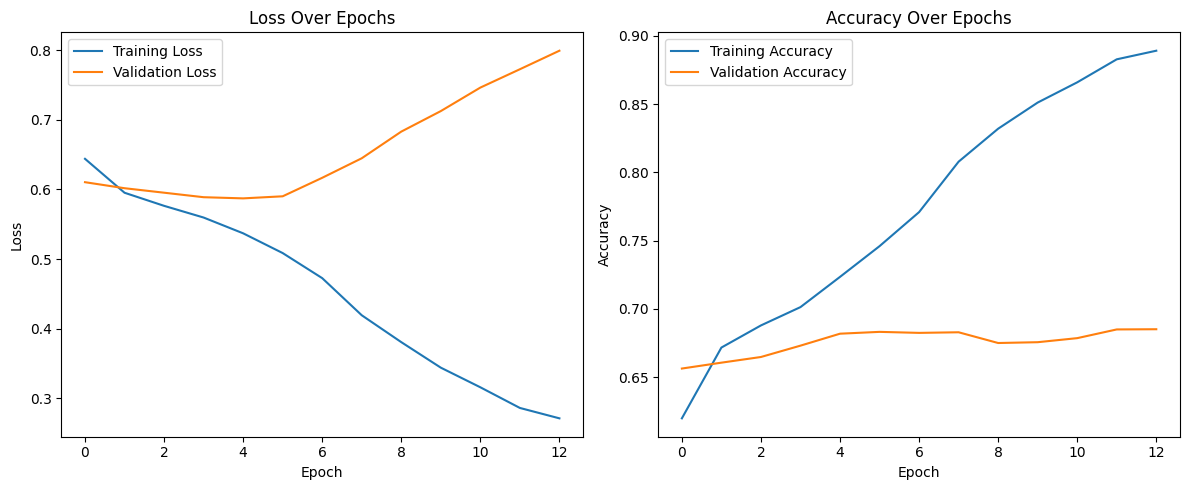

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy or F1 if available
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()